# Predição

Neste notebook, iremos realizar a parte de inferência, verificando os nosso coeficientes e validando nossos coeficientes.

Como isto é uma competição no Kaggle, teremos que verificar por fora os resultados, mas ele serão exibidos aqui.

A sequência de passos será definida da seguinte maneira:


1. Estimar o hiperplano

2. Realizar o cross-validation para evitar overfitting

3. Verificar o resultado no Kaggle

4. Realizar feature selection, baseado no erro do modelo.

5. Verificar modelo final, e gerar métricas

6. Conclusão


# Estimando o hiperplano

In [1]:
# IMPORTAR BIBLIOTECAS
# Libs essenciais
import pandas as pd
import numpy as np

# Importando o modelo e as métricas
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Lendo nosso conjunto de dados, previamente pré-processado
df = pd.read_csv('numeric-train.csv')
df2 = pd.read_csv('numeric-test.csv')

In [3]:
# Dados de treino
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]


# Dados de teste
X_test = df2



In [4]:
# Normalização de X. Iremos usar o StandartScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler

colunas = X_train.columns

scaler = RobustScaler()
X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.2,-0.265787,-0.254076,0.0,0.0,0.0,0.0,0.5,0.0,0.652174,...,0.0,0.000000,0.529412,0.0,0.0,0.0,0.0,0.0,-1.333333,0.0
1,-0.6,0.523686,0.030015,0.0,0.0,0.0,0.0,0.0,3.0,0.065217,...,0.0,1.773810,-0.367647,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.5
2,0.2,-0.107893,0.437624,0.0,-1.0,0.0,0.0,0.5,0.0,0.608696,...,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
3,0.4,-0.528945,0.017663,0.0,-1.0,0.0,0.0,0.5,0.0,-1.260870,...,0.0,0.000000,0.147059,272.0,0.0,0.0,0.0,0.0,-1.333333,-1.0
4,0.2,0.734213,1.181201,0.0,-1.0,0.0,0.0,1.0,0.0,0.586957,...,0.0,1.142857,0.867647,0.0,0.0,0.0,0.0,0.0,2.000000,0.0


In [5]:
# Normalização de X_test. Iremos usar o StandartScaler
colunas = X_test.columns

scaler = RobustScaler()
X_test[colunas] = scaler.fit_transform(X_test[colunas])
X_test.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-0.6,0.634425,0.538713,0.0,0.0,0.0,0.0,-0.5,1.0,-0.250000,...,0.0,0.833333,-0.388889,0.0,0.0,120.0,0.0,0.0,0.00,1.0
1,-0.6,0.689980,1.179692,0.0,-1.0,0.0,0.0,0.0,1.0,-0.312500,...,0.0,2.339286,0.111111,0.0,0.0,0.0,0.0,12500.0,0.00,1.0
2,0.2,0.301091,1.073791,0.0,-1.0,0.0,0.0,-0.5,0.0,0.500000,...,0.0,1.261905,0.083333,0.0,0.0,0.0,0.0,0.0,-0.75,1.0
3,0.2,0.523313,0.140313,0.0,-1.0,0.0,0.0,0.0,1.0,0.520833,...,0.0,2.142857,0.111111,0.0,0.0,0.0,0.0,0.0,0.00,1.0
4,1.4,-1.421131,-1.064825,0.0,-1.0,0.0,0.0,1.0,0.0,0.395833,...,0.0,0.000000,0.750000,0.0,0.0,144.0,0.0,0.0,-1.25,1.0


In [6]:
from sklearn.model_selection import KFold

# K = 10
kf = KFold(n_splits=10)

scores = []

for train, val in kf.split(X_train):
    x_train, x_val = X_train.iloc[train], X_train.iloc[val]
    Y_train, y_val = y_train.iloc[train], y_train.iloc[val]

    lr = LinearRegression()

    # Treina
    lr.fit(x_train, Y_train)

    # Predições
    pred = lr.predict(x_val)

    # Calculando métricas
    r2 = r2_score(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    mape = mean_absolute_percentage_error(y_val, pred)

    if r2 < 0:
        continue
    scores.append((r2, mse, mape))

# Mostrando cada métricas por fold
for i, (r2, mse, mape) in enumerate(scores):
    print(f"Fold {i+1} - R2: {r2:.4f} MSE: {mse:.4f} MAPE: {mape:.4f}")

# Calculando a média dos R2s
print(f"\nMédia R2: {np.mean([r2 for r2, _, _ in scores]):.4f}")

# Calculando a média dos MSEs
print(f"Média MSE: {np.mean([mse for _, mse, _ in scores]):.4f}")

# Calculando a média dos MAPEs
print(f"Média MAPE: {np.mean([mape for _, _, mape in scores]):.4f}")


Fold 1 - R2: 0.8723 MSE: 592445395.3961 MAPE: 0.1235
Fold 2 - R2: 0.8681 MSE: 833622025.6181 MAPE: 0.1106
Fold 3 - R2: 0.8896 MSE: 693475658.1890 MAPE: 0.1205
Fold 4 - R2: 0.7501 MSE: 1714863940.9855 MAPE: 0.1412
Fold 5 - R2: 0.8449 MSE: 1435687901.4974 MAPE: 0.1332
Fold 6 - R2: 0.8410 MSE: 937273267.3432 MAPE: 0.1100
Fold 7 - R2: 0.8332 MSE: 857642000.8631 MAPE: 0.1230
Fold 8 - R2: 0.8437 MSE: 779528923.1610 MAPE: 0.1223
Fold 9 - R2: 0.5229 MSE: 3857872568.8035 MAPE: 0.1337
Fold 10 - R2: 0.8550 MSE: 759573065.4796 MAPE: 0.1307

Média R2: 0.8121
Média MSE: 1246198474.7336
Média MAPE: 0.1249


O resultado não foi tão interessante quanto o esperado. Desta maneira, vamos tentar selecionar as melhores features.

# Seleção de Features

Aqui iremos verificar qual o número de features é a mais adequada para a nossa tarefa, e para validar isto, usaremos o cross-validation, que nos ajudará a entender como nossos dados estão se adequando a reta.

In [7]:
def select_features(num_feat,X,y):


    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LinearRegression
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Create the RFE model and select the top k features
    k = num_feat  # Number of top features to select
    rfe = RFE(estimator=model, n_features_to_select=k)
    X_new = rfe.fit_transform(X, y)
    
    return X_new

In [8]:
from sklearn.model_selection import KFold

# K = 10

for i in range(2,X_train.shape[1]):
    X_new = select_features(i,X_train,y_train)
    print(f"Dim = {i}")
    scores = []

    for j in range(0, 30):
        kf = KFold(n_splits=10,shuffle=True)
        
        
        
        for train, val in kf.split(X_new):
            x_train, x_val = X_new[train], X_new[val]
            Y_train, y_val = y_train.iloc[train], y_train.iloc[val]
            N = len(train)
            
            lr = LinearRegression()
        
            # Treina
            lr.fit(x_train, Y_train)
        
            # Predições
            pred = lr.predict(x_val)
        
            # Calculando métricas
            r2 = r2_score(y_val, pred)
    
            adj_r2 = 1- (1-r2)* ( (N-1)/ (N-1-i) )
            mse = mean_squared_error(y_val, pred)
            mape = mean_absolute_percentage_error(y_val, pred)
        
            if adj_r2 < 0:
                break
            scores.append((adj_r2, mse, mape))
        
    
    # Calculando a média dos R2s
    print(f"\nMédia R2 Ajustado: {np.mean([r2 for r2, _, _ in scores]):.4f}")
    
    # Calculando a média dos MSEs
    print(f"Média MSE: {np.mean([mse for _, mse, _ in scores]):.4f}")
    
    # Calculando a média dos MAPEs
    print(f"Média MAPE: {np.mean([mape for _, _, mape in scores]):.4f}\n\n")


Dim = 2

Média R2 Ajustado: 0.6846
Média MSE: 1962433940.3505
Média MAPE: 0.1831


Dim = 3

Média R2 Ajustado: 0.7259
Média MSE: 1688304571.9306
Média MAPE: 0.1661


Dim = 4

Média R2 Ajustado: 0.7450
Média MSE: 1568568491.1120
Média MAPE: 0.1574


Dim = 5

Média R2 Ajustado: 0.7634
Média MSE: 1474303609.2127
Média MAPE: 0.1480


Dim = 6

Média R2 Ajustado: 0.7614
Média MSE: 1478649511.6654
Média MAPE: 0.1482


Dim = 7

Média R2 Ajustado: 0.7645
Média MSE: 1451471964.6939
Média MAPE: 0.1474


Dim = 8

Média R2 Ajustado: 0.7732
Média MSE: 1393328101.8489
Média MAPE: 0.1434


Dim = 9

Média R2 Ajustado: 0.7799
Média MSE: 1363262659.9934
Média MAPE: 0.1410


Dim = 10

Média R2 Ajustado: 0.7824
Média MSE: 1345272999.6113
Média MAPE: 0.1401


Dim = 11

Média R2 Ajustado: 0.7835
Média MSE: 1349588918.9804
Média MAPE: 0.1403


Dim = 12

Média R2 Ajustado: 0.7907
Média MSE: 1298433858.9770
Média MAPE: 0.1369


Dim = 13

Média R2 Ajustado: 0.7952
Média MSE: 1279769576.2987
Média MAPE: 0.1354




Acima, podemos verificar quais as melhores configurações para o nosso conjunto de treino, e podemos validar. É interessante notar, que como rodamos 30 vezes cada configuração, podemos ter uma média próxima da normal, o que faz com que possamos ter um bom entendimento dos resultados.

# Decidindo o shape

Após realizar diversos testes, decidimos que iremos escolher 24 e 25
atributos para serem utilizados. Além disso, podemos descobrir quais são esses atributos, para facilitar nossos processamentos. Efetuando 2 submissões.

In [9]:
def select_features(num_feat,X,y):


    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LinearRegression
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Create the RFE model and select the top k features
    k = num_feat  # Number of top features to select
    rfe = RFE(estimator=model, n_features_to_select=k)
    X_new = rfe.fit_transform(X, y)
    
    return X_new, X.loc[:,rfe.get_support()].columns

In [10]:
X_24,cols_24 = select_features(24,X_train,y_train)
X_25,cols_25 = select_features(25,X_train,y_train)

Assim, podemos manter, apenas estes atributos no conjunto de teste, para a submissão no Kaggle.

In [11]:
cols_24

Index(['MSSubClass', 'Street', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
       'GarageCars'],
      dtype='object')

In [12]:
cols_25

Index(['MSSubClass', 'Street', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
       'GarageCars', 'GarageQual'],
      dtype='object')

In [13]:
# Datasets de validação de acordo com os datasets de treino
X_test_24 = X_test.loc[:,cols_24]
X_test_25 = X_test.loc[:,cols_25]

In [14]:
# Verificando o dataset de 31 atributos
X_test_24.head()

,MSSubClass,Street,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,BsmtQual,...,2ndFlrSF,GrLivArea,BsmtFullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageCars
0,-0.6,0.0,0.0,0.0,-0.5,1.0,-0.250000,0.000000,0.0,0.0,...,0.000000,-0.888152,0.0,-1.0,0.0,0.0,-0.5,0.0,0.00,-1.0
1,-0.6,0.0,0.0,0.0,0.0,1.0,-0.312500,0.666667,0.0,0.0,...,0.000000,-0.170671,0.0,0.0,0.0,1.0,0.0,0.0,0.00,-1.0
2,0.2,0.0,0.0,0.0,-0.5,0.0,0.500000,0.000000,0.0,1.0,...,1.036982,0.326429,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0
3,0.2,0.0,0.0,0.0,0.0,1.0,0.520833,0.123457,0.0,0.0,...,1.002959,0.285004,0.0,0.0,0.0,1.0,0.5,0.0,1.00,0.0
4,1.4,0.0,0.0,0.0,1.0,0.0,0.395833,0.000000,1.0,1.0,...,0.000000,-0.251864,0.0,-1.0,0.0,1.0,-0.5,0.0,0.00,0.0


In [15]:
# Verificando o dataset de 40 atributos
X_test_25.head()

,MSSubClass,Street,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,BsmtQual,...,GrLivArea,BsmtFullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageCars,GarageQual
0,-0.6,0.0,0.0,0.0,-0.5,1.0,-0.250000,0.000000,0.0,0.0,...,-0.888152,0.0,-1.0,0.0,0.0,-0.5,0.0,0.00,-1.0,0.0
1,-0.6,0.0,0.0,0.0,0.0,1.0,-0.312500,0.666667,0.0,0.0,...,-0.170671,0.0,0.0,0.0,1.0,0.0,0.0,0.00,-1.0,0.0
2,0.2,0.0,0.0,0.0,-0.5,0.0,0.500000,0.000000,0.0,1.0,...,0.326429,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
3,0.2,0.0,0.0,0.0,0.0,1.0,0.520833,0.123457,0.0,0.0,...,0.285004,0.0,0.0,0.0,1.0,0.5,0.0,1.00,0.0,0.0
4,1.4,0.0,0.0,0.0,1.0,0.0,0.395833,0.000000,1.0,1.0,...,-0.251864,0.0,-1.0,0.0,1.0,-0.5,0.0,0.00,0.0,0.0


No Kaggle, existe um formato para realizar a submissão, e assim precisamos construir o conjunto de dados da melhor maneira.

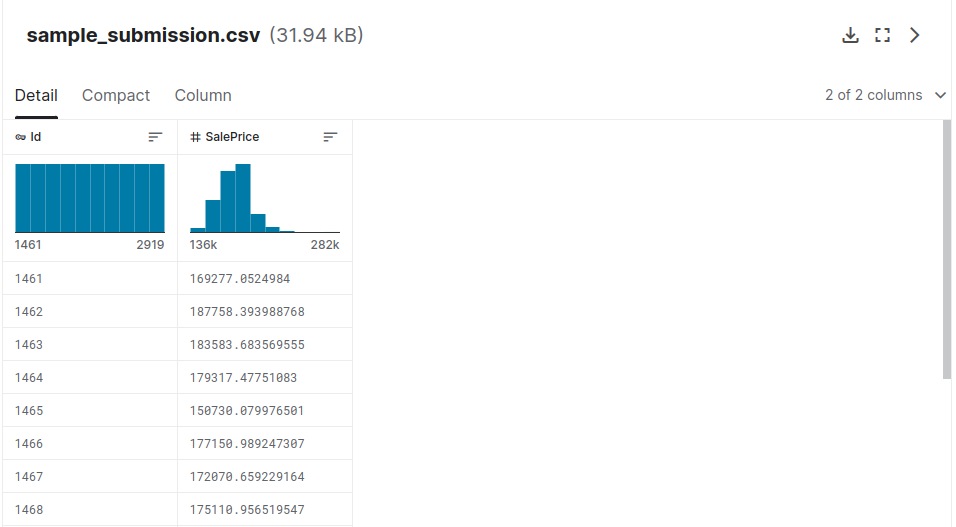

In [16]:
# Criando datasets de submissão
sub_24 = pd.DataFrame()
sub_25 = pd.DataFrame()

In [17]:
# Adicionando o ID do objeto
sub_24['Id'] = range(1461,2920)
sub_25['Id'] = range(1461,2920)

In [18]:
# Fazendo as predições

# Para 31 atributos
lr = LinearRegression()

# Treina
lr.fit(X_24, y_train)

# Predições
pred = lr.predict(X_test_24.values)

sub_24['SalePrice'] = pred

# Para 40 atributos

lr = LinearRegression()

# Treina
lr.fit(X_25, y_train)

# Predições
pred = lr.predict(X_test_25.values)

sub_25['SalePrice'] = pred


In [19]:
sub_24.to_csv("24feat.csv",index=False)

In [20]:
sub_25.to_csv("25feat.csv",index=False)

Após a submissão, podemos verificar os resultados na próxima seção. Obviamente, poderíamos ter utilizado modelos melhores, para obter melhores resultados, entretanto, o interessante era utilizar apenas regressão linear, sem combinação nem nada.

Os scores foram o seguinte: Vai de 0 ao infinito.

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 


sub_24 = 0.18274

sub_25 = 0.17796

Assim, o dataset com 25 features teve um melhor desemepenho.

# Conclusão

Podemos concluir que a nossa análise e regressão foi muito bem sucedida, pois apenas utilizando dados numéricos do conjunto de dados, não utilizando combinação de modelos, e nem tećnica para melhorar o modelo diretamente, conseguimos alcançar um bom score, com valor muito próximo de zero. Além disso, foi possível realizar diversas tećnicas de processamento muito interessantes. Finalmente, destaca-se que a coisa mais importante, foi a escolha correta do normalizador, visto que como tinhámos outliers, utilizar o RobustScaler trouxe uma adequação melhor dos dados.

Assim, concluímos esta experiência como positiva.